## 0. Preliminaries


**Importing Necessary Modules**
First, we import the modules that we will be using.  Some modules are imported later on as needed. (Not great python practice, but it will let us talk about new functions as we need them.)

In [1]:
## Standard Modules for Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Metrics to help evaluate the models
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

**Importing Neural Network Software**  Below, we import the components of the TensorFlow library we need to build this network.


In [2]:
## TensorFlow/Keras, for building Neural Network Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D


**Mounting the Google Drive**

This assumes you have previously downloaded the data science camp GitHub repository, and are running this notebook from its location in that repository.  Otherwise, you may need to adjust the path to the data as needed.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [8]:
## Change the current directory
%cd '/content/gdrive/My Drive/dscamp/dscamp_public/Advanced Models I'

/content/gdrive/My Drive/dscamp/dscamp_public/Advanced Models I


In [9]:
## utility Functions for later
def plot_learning_loss(hst):
    """
    Input:
    ---------------
    hst - The training history from a keras model
    
    Returns:
    ---------------
    A figure object with learning curves showing the loss (and accuracy, if available)
    
    """
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    ax.plot(hst.history['loss'], label='Training')
    if 'val_loss' in hst.history.keys():
        ax.plot(hst.history['val_loss'], label='Validation')
        ax.legend()
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss')
    return fig
    

# 1 Read and Prepare Data

In this Section, we read in the data, both the data about the members of the network, and the images.




## 1.1 Prepare the Response Data

We recover the ages of the individuals from the data set we were working with earlier.


In [10]:
## Here, we read in the original data.
df = pd.read_csv('data/face_data2.csv', index_col="face_id")

In [11]:
## Recall the Variables that are included in the data:
df.columns

Index(['age', 'gender', 'relationship', 'music_genre', 'band', 'team',
       'first_name', 'last_name', 'education', 'education_prompt', 'work',
       'work_prompt', 'fav_movie_1', 'fav_movie_2', 'fav_book_1', 'fav_book_2',
       'fav_book_3', 'fav_auth_1', 'fav_auth_2', 'fav_auth_3', 'fav_food_1',
       'fav_food_2', 'fav_food_3', 'home_city', 'home_state', 'languages',
       'hogwarts', 'fav_pet', 'vg_genre', 'fav_video_game', 'spouse_id',
       'n_friends', 'credit', 'gender_female', 'gender_male',
       'relationship_married', 'relationship_single', 'relationship_widowed',
       'music_genre_classical', 'music_genre_country',
       'music_genre_electronic', 'music_genre_folk', 'music_genre_heavy metal',
       'music_genre_hip-hop', 'music_genre_jazz', 'music_genre_rock',
       'music_genre_tibetian throat singing', 'hogwarts_gryffindor',
       'hogwarts_hufflepuff', 'hogwarts_ravenclaw', 'hogwarts_slytherin',
       'fav_pet_birds', 'fav_pet_cats', 'fav_pet_dogs', 'fav_

Since we will be trying to predict the ages of the individuals from their pictures, we should select those values as the response.

In [12]:
y = df['age'].values

(array([ 70.,  36.,  26., 128., 211., 253., 138.,  90.,  32.,  16.]),
 array([ 0. ,  6.2, 12.4, 18.6, 24.8, 31. , 37.2, 43.4, 49.6, 55.8, 62. ]),
 <a list of 10 Patch objects>)

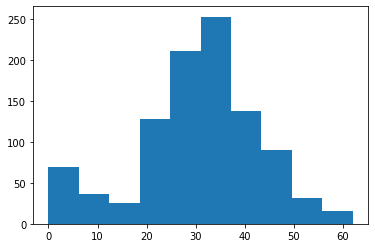

In [26]:
plt.hist(y)

## 1.2 Prepare the Features

Unlike earlier models, the features the model will use to learn and predict ages are the images of the person themselves, rather than other variables.

The images have been stored in a 3-dimensional array, and may be read into memory as shown below.

In [27]:
## Read in the pictures of each of the individuals
x = np.load('data/faces128_gray.npy')

In [28]:
x.shape

(1000, 64, 64, 1)

What does each image look like?  To the computer, it looks like this:

In [29]:
x[0, :, :].reshape(64, 64)

array([[ 90,  96, 103, ...,  84,  82,  78],
       [ 92,  97, 105, ...,  88,  86,  83],
       [ 92,  99, 108, ...,  97,  95,  93],
       ...,
       [173, 168, 164, ..., 124, 122, 108],
       [167, 167, 163, ..., 120, 105, 113],
       [162, 162, 158, ..., 109, 121, 123]], dtype=uint8)

Which is a way of representing this image:

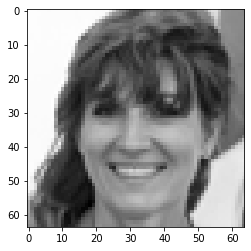

In [30]:
plt.imshow(x[888, :, :,0], cmap='gray')

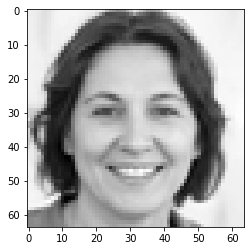

In [31]:
## To look at another image:
plt.imshow(x[666, :, :,0], cmap='gray')

## 1.3 Separate Data into Train and Test

We can again use the train_test_split function from scikit-learn to separate our data into training and testing sets. 

We continue to use the same seed as before, so our training and testing sets are consistent.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [33]:
X_train.shape

(800, 64, 64, 1)

## 1.4 Scale the data

Since in this image data, we know that we the intensity of each pixel can be between 0 and 255, we can easily scale the data by dividing by 255.  

This is very similar to MinMax Scaling, 

In [34]:
X_train = X_train/255
X_test = X_test/255

# 2 Build a Convolutional Neural Network

We are finally ready to build the network model.  Since we are working with images as predictors, we will build the network with 2 dimensional convlutional layers.  These structures are particularly good at representing images.

In [35]:
model1 = Sequential()
model1.add(Conv2D(20, 8, 8, input_shape=(64, 64, 1), padding='same', activation='relu'))
model1.add(Dropout(0.2))
model1.add(Conv2D(50, 3, 3, activation='relu', padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='linear'))

In [36]:
model1.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
trn_hist = model1.fit(X_train, y_train, batch_size=60, epochs=100, verbose=1, validation_data=(X_test, y_test))



Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 1043.7432 - val_loss: 833.9283
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 497.8292 - val_loss: 261.5681
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 214.6269 - val_loss: 216.0822
Epoch 4/100
14/14 [==============================] - 0s 13ms/step - loss: 183.4207 - val_loss: 202.2083
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 175.9734 - val_loss: 196.6496
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 173.4526 - val_loss: 194.4348
Epoch 7/100
14/14 [==============================] - 0s 12ms/step - loss: 170.6559 - val_loss: 193.6268
Epoch 8/100
14/14 [==============================] - 0s 13ms/step - loss: 174.7844 - val_loss: 192.6762
Epoch 9/100
14/14 [==============================] - 0s 13ms/step - loss: 175.4514 - val_loss: 195.8930
Epoch 10/100
14/14 [==============================] - 0s 15ms/s

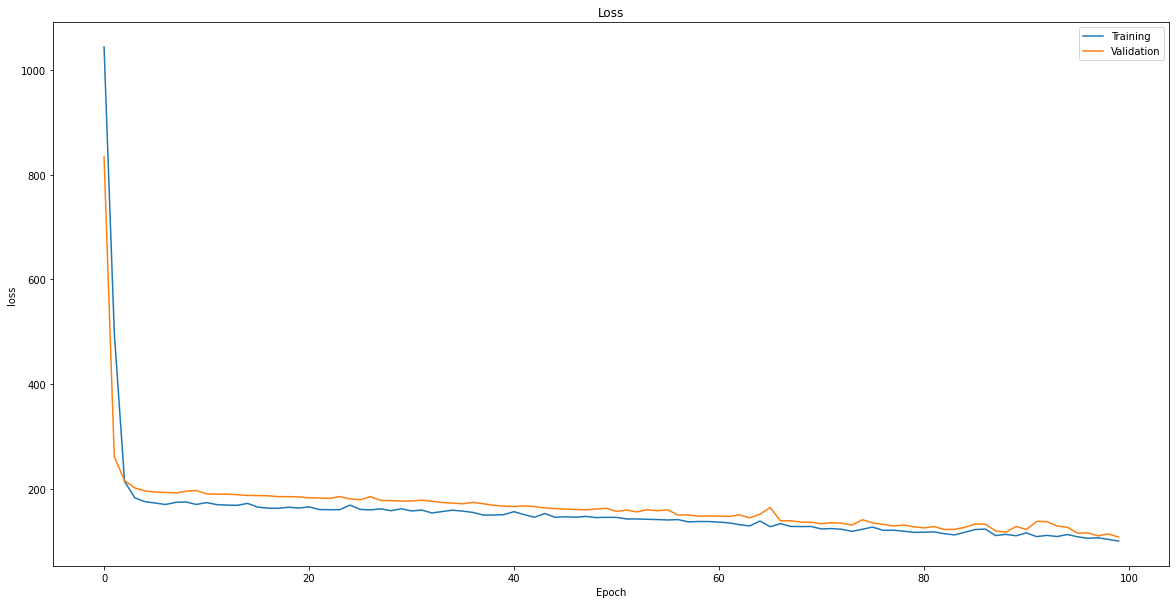

In [38]:
fig = plot_learning_loss(trn_hist)

In [39]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model1.predict(X_train)
yhat_test = model1.predict(X_test)



In [40]:
mean_squared_error(y_train, yhat_train)

88.8757664663677

In [41]:
mean_squared_error(y_test, yhat_test)

108.47231016832075

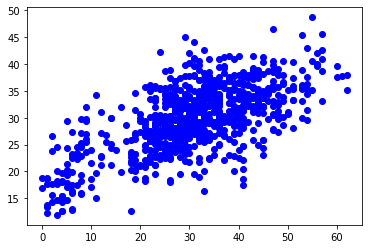

In [42]:
plt.plot(y_train, yhat_train, 'bo')


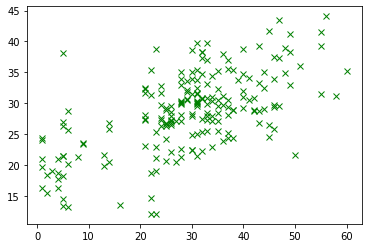

In [43]:
plt.plot(y_test, yhat_test, 'gx')

**Try a Second Model:** Here we try a different model.  How does it compare?

In [44]:
model2 = Sequential()
model2.add(Conv2D(20, (5, 5), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(50, (5, 5), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(1, activation='linear'))

In [45]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
trn_hist = model2.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test))



Epoch 1/50
25/25 [==============================] - 9s 333ms/step - loss: 271.1028 - val_loss: 192.4861
Epoch 2/50
25/25 [==============================] - 8s 317ms/step - loss: 167.2183 - val_loss: 249.0259
Epoch 3/50
25/25 [==============================] - 8s 318ms/step - loss: 172.9006 - val_loss: 180.7874
Epoch 4/50
25/25 [==============================] - 8s 319ms/step - loss: 159.6783 - val_loss: 176.9094
Epoch 5/50
25/25 [==============================] - 8s 321ms/step - loss: 150.9477 - val_loss: 171.2449
Epoch 6/50
25/25 [==============================] - 8s 321ms/step - loss: 137.1249 - val_loss: 167.9435
Epoch 7/50
25/25 [==============================] - 8s 330ms/step - loss: 125.2175 - val_loss: 137.4368
Epoch 8/50
25/25 [==============================] - 10s 393ms/step - loss: 114.9131 - val_loss: 116.0838
Epoch 9/50
25/25 [==============================] - 8s 325ms/step - loss: 104.3398 - val_loss: 112.4509
Epoch 10/50
25/25 [==============================] - 8s 323ms/s

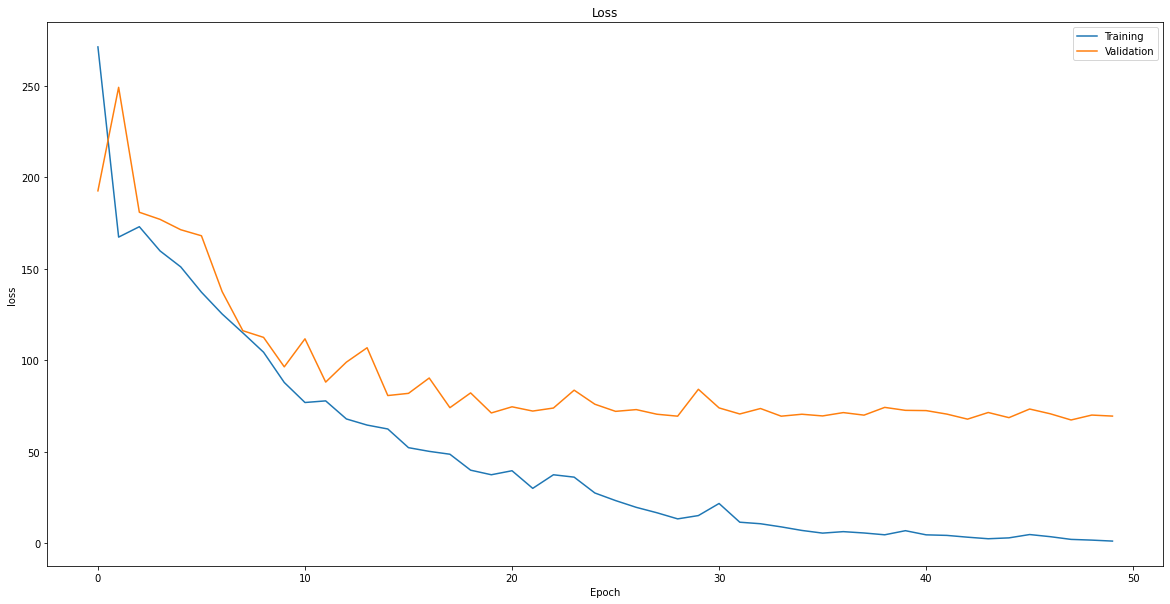

In [47]:
fig = plot_learning_loss(trn_hist)

In [48]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model2.predict(X_train)
yhat_test = model2.predict(X_test)



In [49]:
mean_squared_error(y_train, yhat_train)

0.9264047102344491

In [50]:
mean_squared_error(y_test, yhat_test)

69.45506067142531

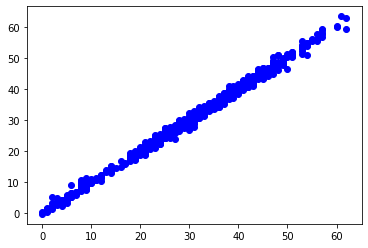

In [51]:
plt.plot(y_train, yhat_train, 'bo')


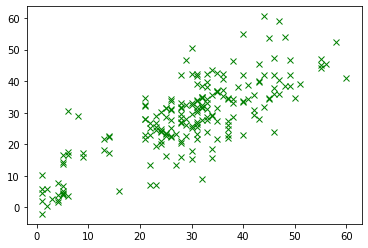

In [52]:
plt.plot(y_test, yhat_test, 'gx')

# 3 Large, Color CNN

In this portion, we use a larger data set, that has color pictures.

## 3.1 Read In Larger Images

Here we read from a different file, with larger images.

In [53]:
## Read in the pictures of each of the individuals
x = np.load('data/faces256.npy')

In [54]:
x.shape

(1000, 128, 128, 3)

What does each image look like?  To the computer, it looks like this:

In [55]:
x[0, :, :].reshape(128, 128, 3)

array([[[109,  87,  47],
        [113,  89,  50],
        [116,  91,  54],
        ...,
        [103,  77,  44],
        [ 98,  75,  40],
        [ 94,  75,  40]],

       [[111,  87,  49],
        [113,  89,  51],
        [116,  91,  54],
        ...,
        [104,  79,  45],
        [102,  77,  42],
        [ 99,  76,  41]],

       [[111,  88,  49],
        [112,  89,  52],
        [117,  93,  54],
        ...,
        [106,  81,  46],
        [105,  79,  45],
        [103,  77,  45]],

       ...,

       [[151, 172, 179],
        [156, 174, 181],
        [155, 173, 180],
        ...,
        [ 99, 118, 125],
        [105, 124, 131],
        [106, 127, 135]],

       [[150, 170, 176],
        [153, 170, 175],
        [151, 169, 176],
        ...,
        [112, 131, 138],
        [109, 129, 137],
        [107, 127, 134]],

       [[141, 165, 173],
        [145, 164, 171],
        [146, 166, 174],
        ...,
        [114, 133, 141],
        [109, 128, 136],
        [107, 128, 135]]

Which is a way of representing this image:

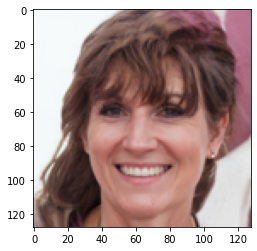

In [56]:
plt.imshow(x[888, :, :])

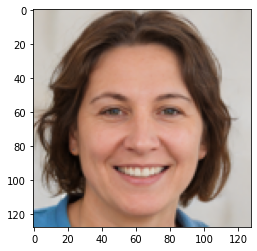

In [57]:
## To look at the second image:
plt.imshow(x[666, :, :,:])

## 3.2 Process the data

We can again use the train_test_split function from scikit-learn to separate our data into training and testing sets. 

We continue to use the same seed as before, so our training and testing sets are consistent.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [59]:
X_train.shape

(800, 128, 128, 3)


Since in this image data, we know that we the intensity of each pixel can be between 0 and 255, we can easily scale the data by dividing by 255.  



In [60]:
X_train = X_train/255
X_test = X_test/255

In [61]:
model3 = Sequential()
model3.add(Conv2D(20, (5, 5), input_shape=(128, 128, 3), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(Conv2D(50, (5, 5), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(1, activation='linear'))

In [62]:
model3.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
trn_hist = model3.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test))



Epoch 1/50
25/25 [==============================] - 34s 1s/step - loss: 266.4002 - val_loss: 193.7774
Epoch 2/50
25/25 [==============================] - 33s 1s/step - loss: 161.5427 - val_loss: 193.2635
Epoch 3/50
25/25 [==============================] - 32s 1s/step - loss: 150.0981 - val_loss: 152.9105
Epoch 4/50
25/25 [==============================] - 33s 1s/step - loss: 136.6048 - val_loss: 145.4869
Epoch 5/50
25/25 [==============================] - 33s 1s/step - loss: 120.1299 - val_loss: 121.7365
Epoch 6/50
25/25 [==============================] - 33s 1s/step - loss: 96.9751 - val_loss: 95.3189
Epoch 7/50
25/25 [==============================] - 33s 1s/step - loss: 83.3609 - val_loss: 89.3061
Epoch 8/50
25/25 [==============================] - 33s 1s/step - loss: 85.4713 - val_loss: 83.6041
Epoch 9/50
25/25 [==============================] - 33s 1s/step - loss: 65.3789 - val_loss: 81.5924
Epoch 10/50
25/25 [==============================] - 33s 1s/step - loss: 58.7344 - val_los

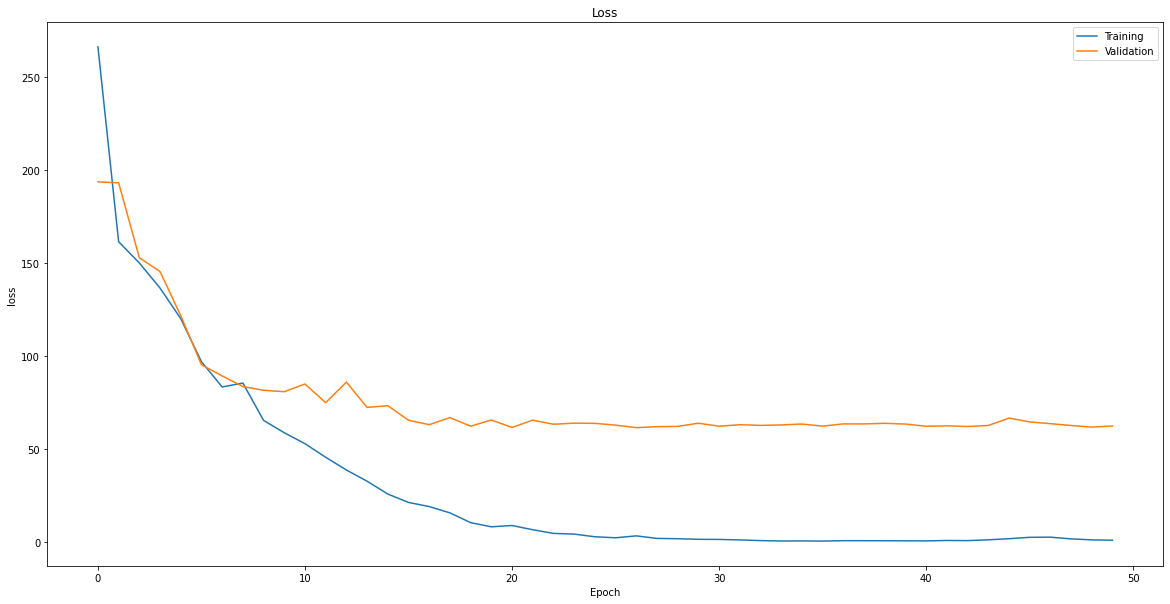

In [64]:
fig = plot_learning_loss(trn_hist)

In [65]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model3.predict(X_train)
yhat_test = model3.predict(X_test)



In [66]:
mean_squared_error(y_train, yhat_train)

0.4022830221820253

In [67]:
mean_squared_error(y_test, yhat_test)

62.38589924761653

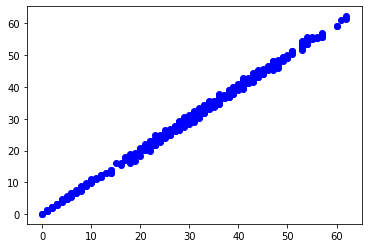

In [68]:
plt.plot(y_train, yhat_train, 'bo')


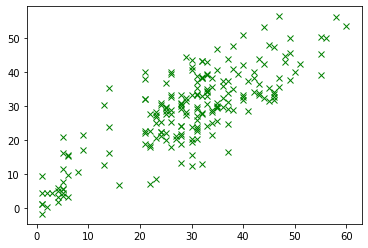

In [69]:
plt.plot(y_test, yhat_test, 'gx')